# Software defect analysis and prediction system

## By Ali Arefi and Jalaj Rastogi

### We utilize the Verisoft parameters to see which programs fall within redesign classification, we explore the relationship between programs designated as redesign and programs that actually failed(defected). Furthermore we will use a RandomForrestClassifer to train a software defect prediction system that will be able to classify new points like likely defective or not based on previous training data. Once optimized to an acceptable performance through validation, we will perform feature importance measures to see which features are more important in the models prediction performance.

In [195]:
#pip install -U imbalanced-learn

In [196]:
#pip install optimalflow

In [197]:
#pip install Matplotlib==3.5.1

In [198]:

#pip install rfpimp

In [199]:

#pip install shap

In [200]:
#pip install tabulate

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN 
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import model_selection
from imblearn.over_sampling import KMeansSMOTE
from imblearn. combine import SMOTETomek
from imblearn. combine import SMOTEENN
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import jaccard_score
from scipy.stats import pointbiserialr
import shap
import lime
import lime.lime_tabular
from tabulate import tabulate
from sklearn.metrics.pairwise import pairwise_distances
from imblearn.over_sampling import SMOTE
from scipy.io import arff
import os


 ### Importing

In [201]:
# Search for arff files
#path_to_directory="./Dataset/"
#files = [arff for arff in os.listdir(path_to_directory) if arff.endswith(".arff")]

In [191]:
# function to convert arff file to list of lines
def toCsv(content): 
    data = False
    header = ""
    newContent = []
    for line in content:
        if not data:
            if "@attribute" in line:
                attri = line.split()
                columnName = attri[attri.index("@attribute")+1]
                header = header + columnName + ","
            elif "@data" in line:
                data = True
                header = header[:-1]
                header += '\n'
                newContent.append(header)
        else:
            newContent.append(line)
    return newContent

# Main loop for reading and writing files
for zzzz,file in enumerate(files):
    with open(path_to_directory+file , "r") as inFile:
        content = inFile.readlines()
        name,ext = os.path.splitext(inFile.name)
        new = toCsv(content)
        with open("csv_result-"+name+".csv", "w") as outFile:
            outFile.writelines(new)

NameError: name 'files' is not defined

### Data cleaning and manipulation- forming the dataframe

In [34]:
df_pc3 = pd.read_csv('csv_result_PC3.csv')
df_pc4 = pd.read_csv('csv_result-PC4.csv')
df_mc1 = pd.read_csv('csv_result-MC1.csv')

In [35]:
df = df_pc3.merge(df_pc4, how = 'outer')

You are merging on int and float columns where the float values are not equal to their int representation


In [36]:
df2 = df[['Defective','c']].fillna('')
df2["defects"] = df2["Defective"].astype('string') + df2["c"].astype('string')
df2 = df2.drop(labels = ['Defective', 'c'], axis = 1)

In [37]:
df['defects'] = df2
df= df.drop(labels = ['Defective', 'c'], axis = 1)

In [38]:
df['defects'] = df['defects'].astype('string')

In [39]:
df['defects'] = df['defects'].str.replace('False', '0')
df['defects'] = df['defects'].str.replace('True', '1')
df['defects'] = df['defects'].str.replace('N', '0')
df['defects'] = df['defects'].str.replace('Y', '1')

In [40]:
df['defects'] = df['defects'].astype('int64')

In [41]:
df = df.merge(df_mc1, how = 'outer')

In [42]:
df = df.merge(df_mc1, how = 'outer')
# maybe set nans to an empty string
df3 = df[['Defective','defects']].fillna('')
df3["defected"] = df3["Defective"].astype('string') + df3["defects"].astype('string')
df3 = df3.drop(labels = ['Defective', 'defects'], axis = 1)
df['defected'] = df3
df_f = df.drop(['defects','Defective'], axis = 1)
df_f['defected'] = df_f['defected'].astype('string')
df_f['defected'] = df_f['defected'].str.replace('False', '0')
df_f['defected'] = df_f['defected'].str.replace('True', '1')
df_f['defected'] = df_f['defected'].str.replace('N', '0')
df_f['defected'] = df_f['defected'].str.replace('Y', '1')
df_f['defected'] = df_f['defected'].astype('float')

In [43]:
df_f.head()

,id,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,...,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,GLOBAL_DATA_COMPLEXITY,GLOBAL_DATA_DENSITY,defected
0,1,16,13,1,6,11,20,7,0.24,8,...,68,81,31,21,57,42.50,29,NaN,NaN,0.0
1,2,2,7,0,0,7,10,4,0.29,4,...,9,22,5,8,24,33.33,14,NaN,NaN,1.0
2,3,1,13,5,0,0,22,7,0.37,10,...,38,53,19,19,21,0.00,19,NaN,NaN,0.0
3,4,8,3,1,0,1,4,2,0.14,2,...,32,38,19,13,24,6.67,14,NaN,NaN,0.0
4,5,1,5,2,1,1,6,3,0.15,2,...,27,33,19,14,23,9.52,20,NaN,NaN,0.0


### Correlation of entire dataset

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


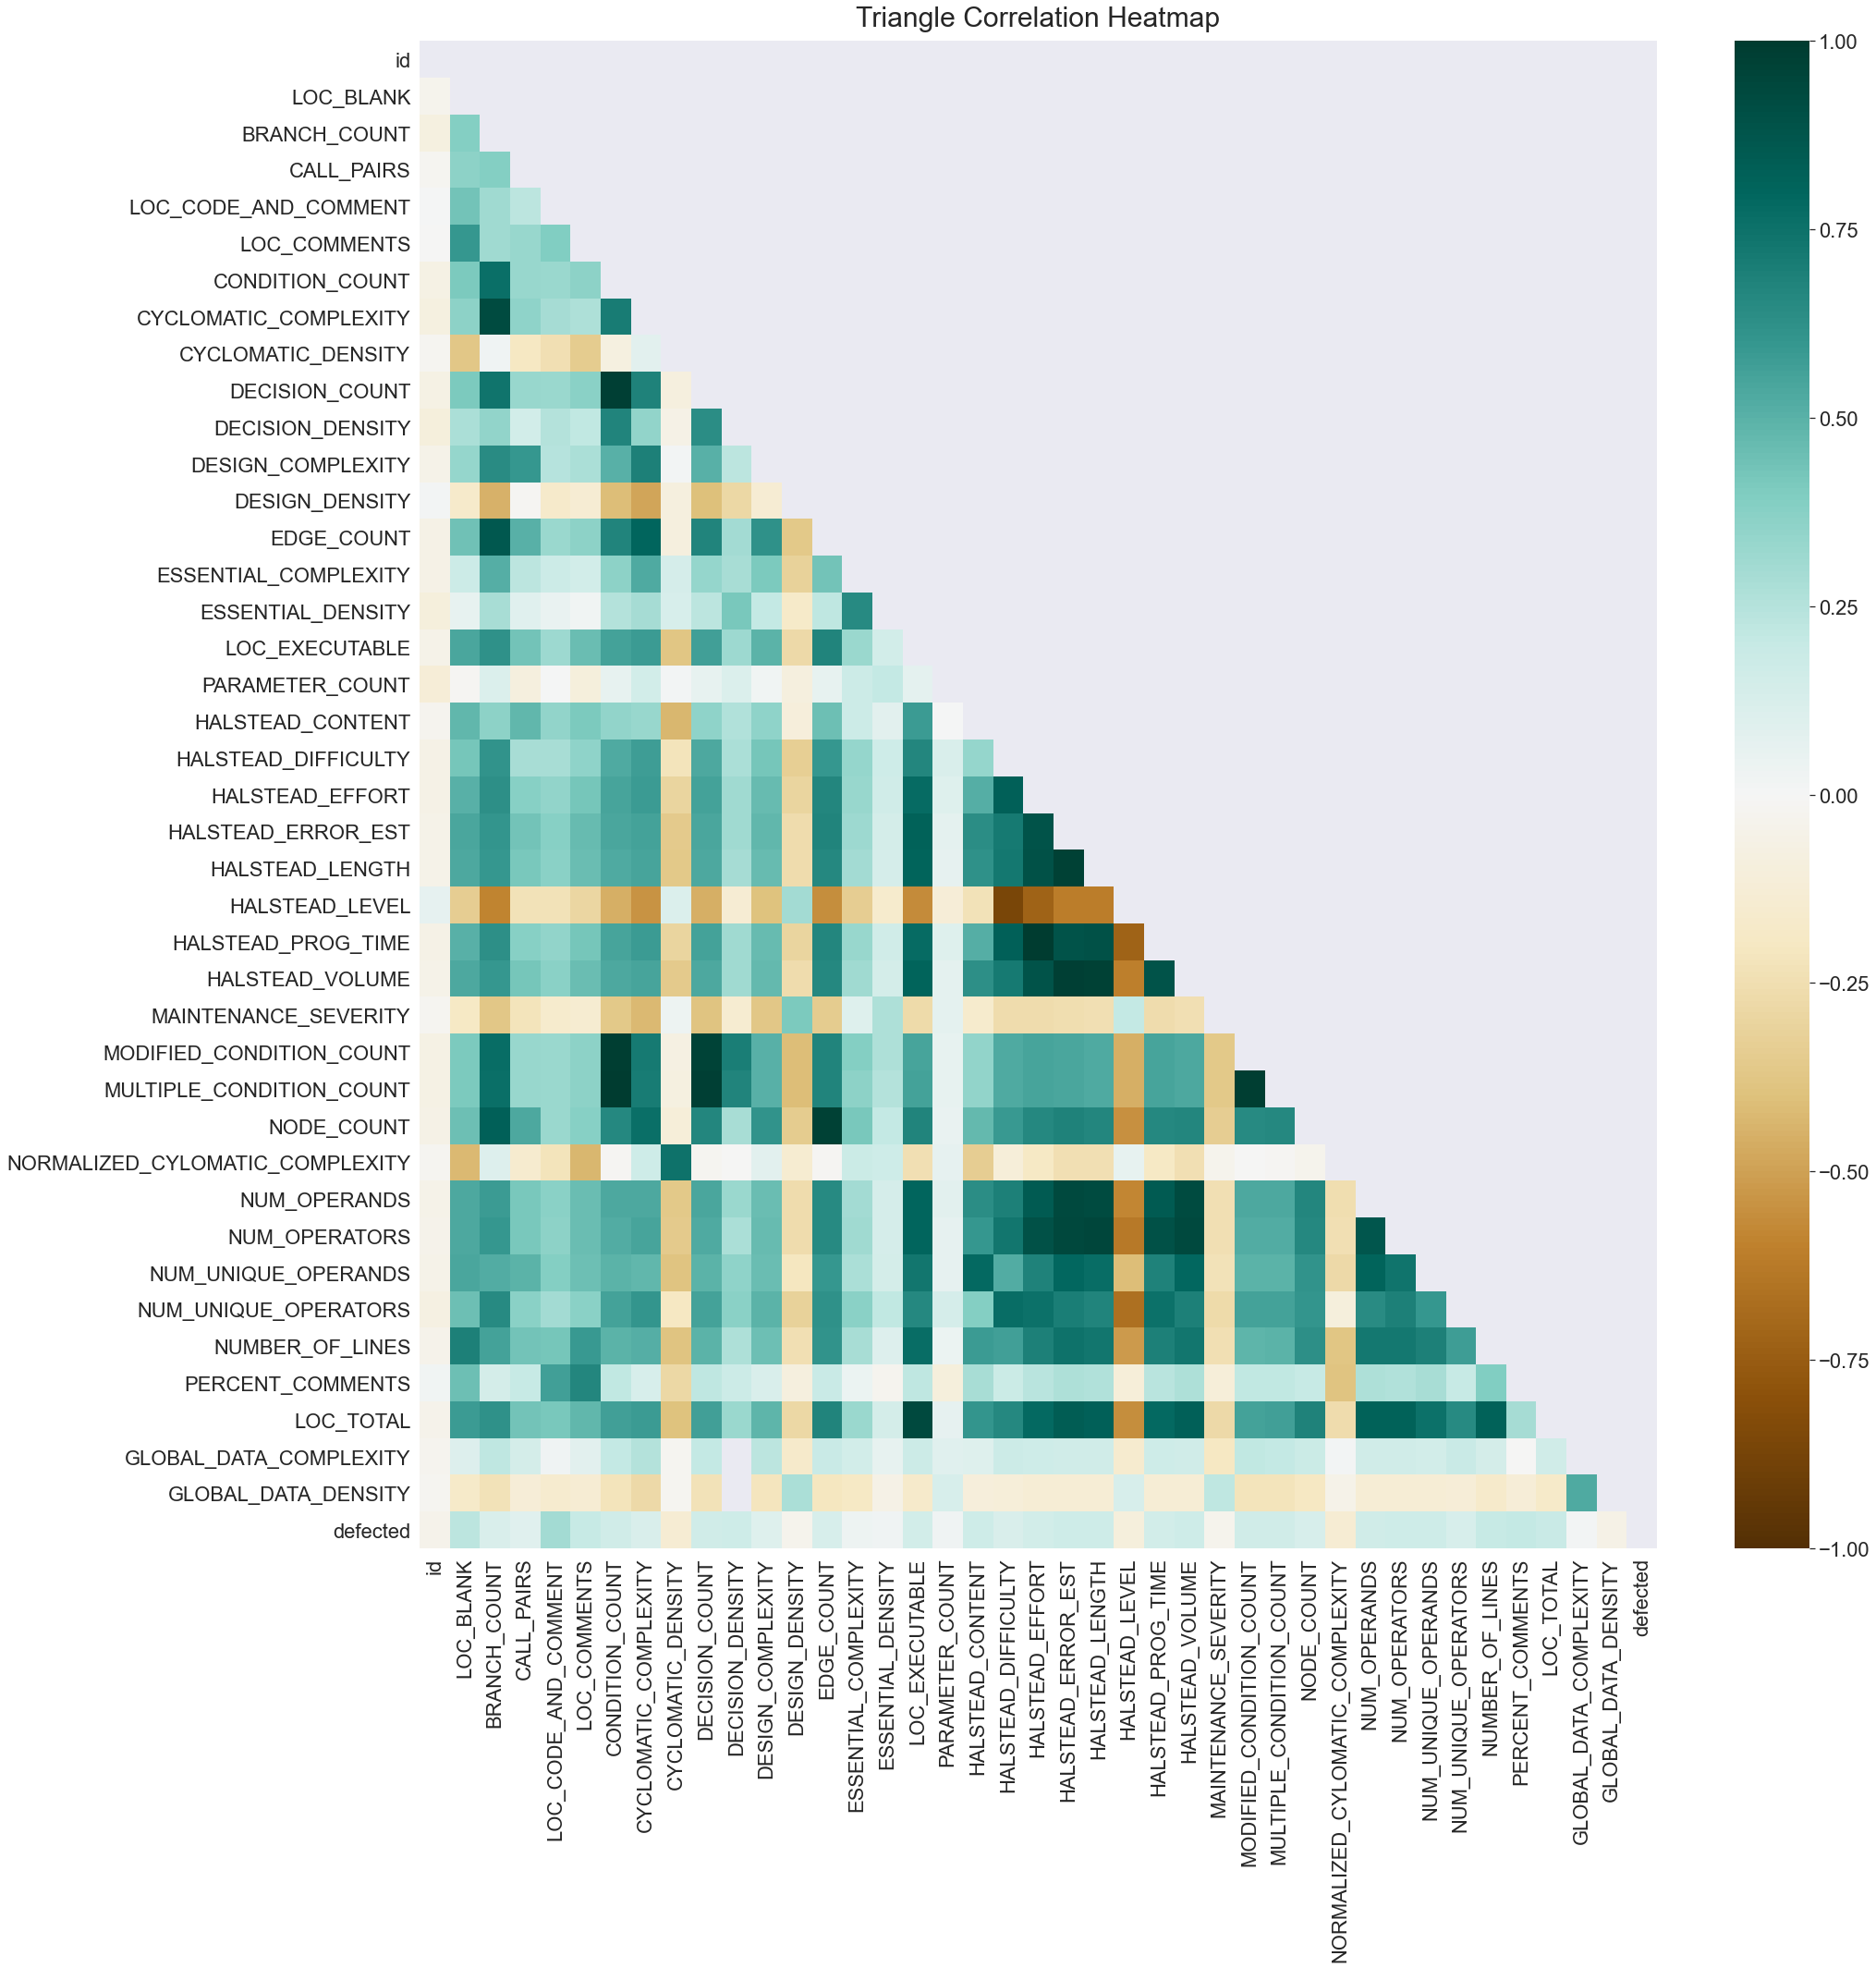

In [44]:
sns.set(font_scale=2)
np.triu(np.ones_like(df_f.corr(method = 'kendall')))
plt.figure(figsize=(30, 30))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_f.corr(method = 'kendall'), dtype=np.bool))
heatmap = sns.heatmap(df_f.corr(method = 'kendall'), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':30}, pad=16);

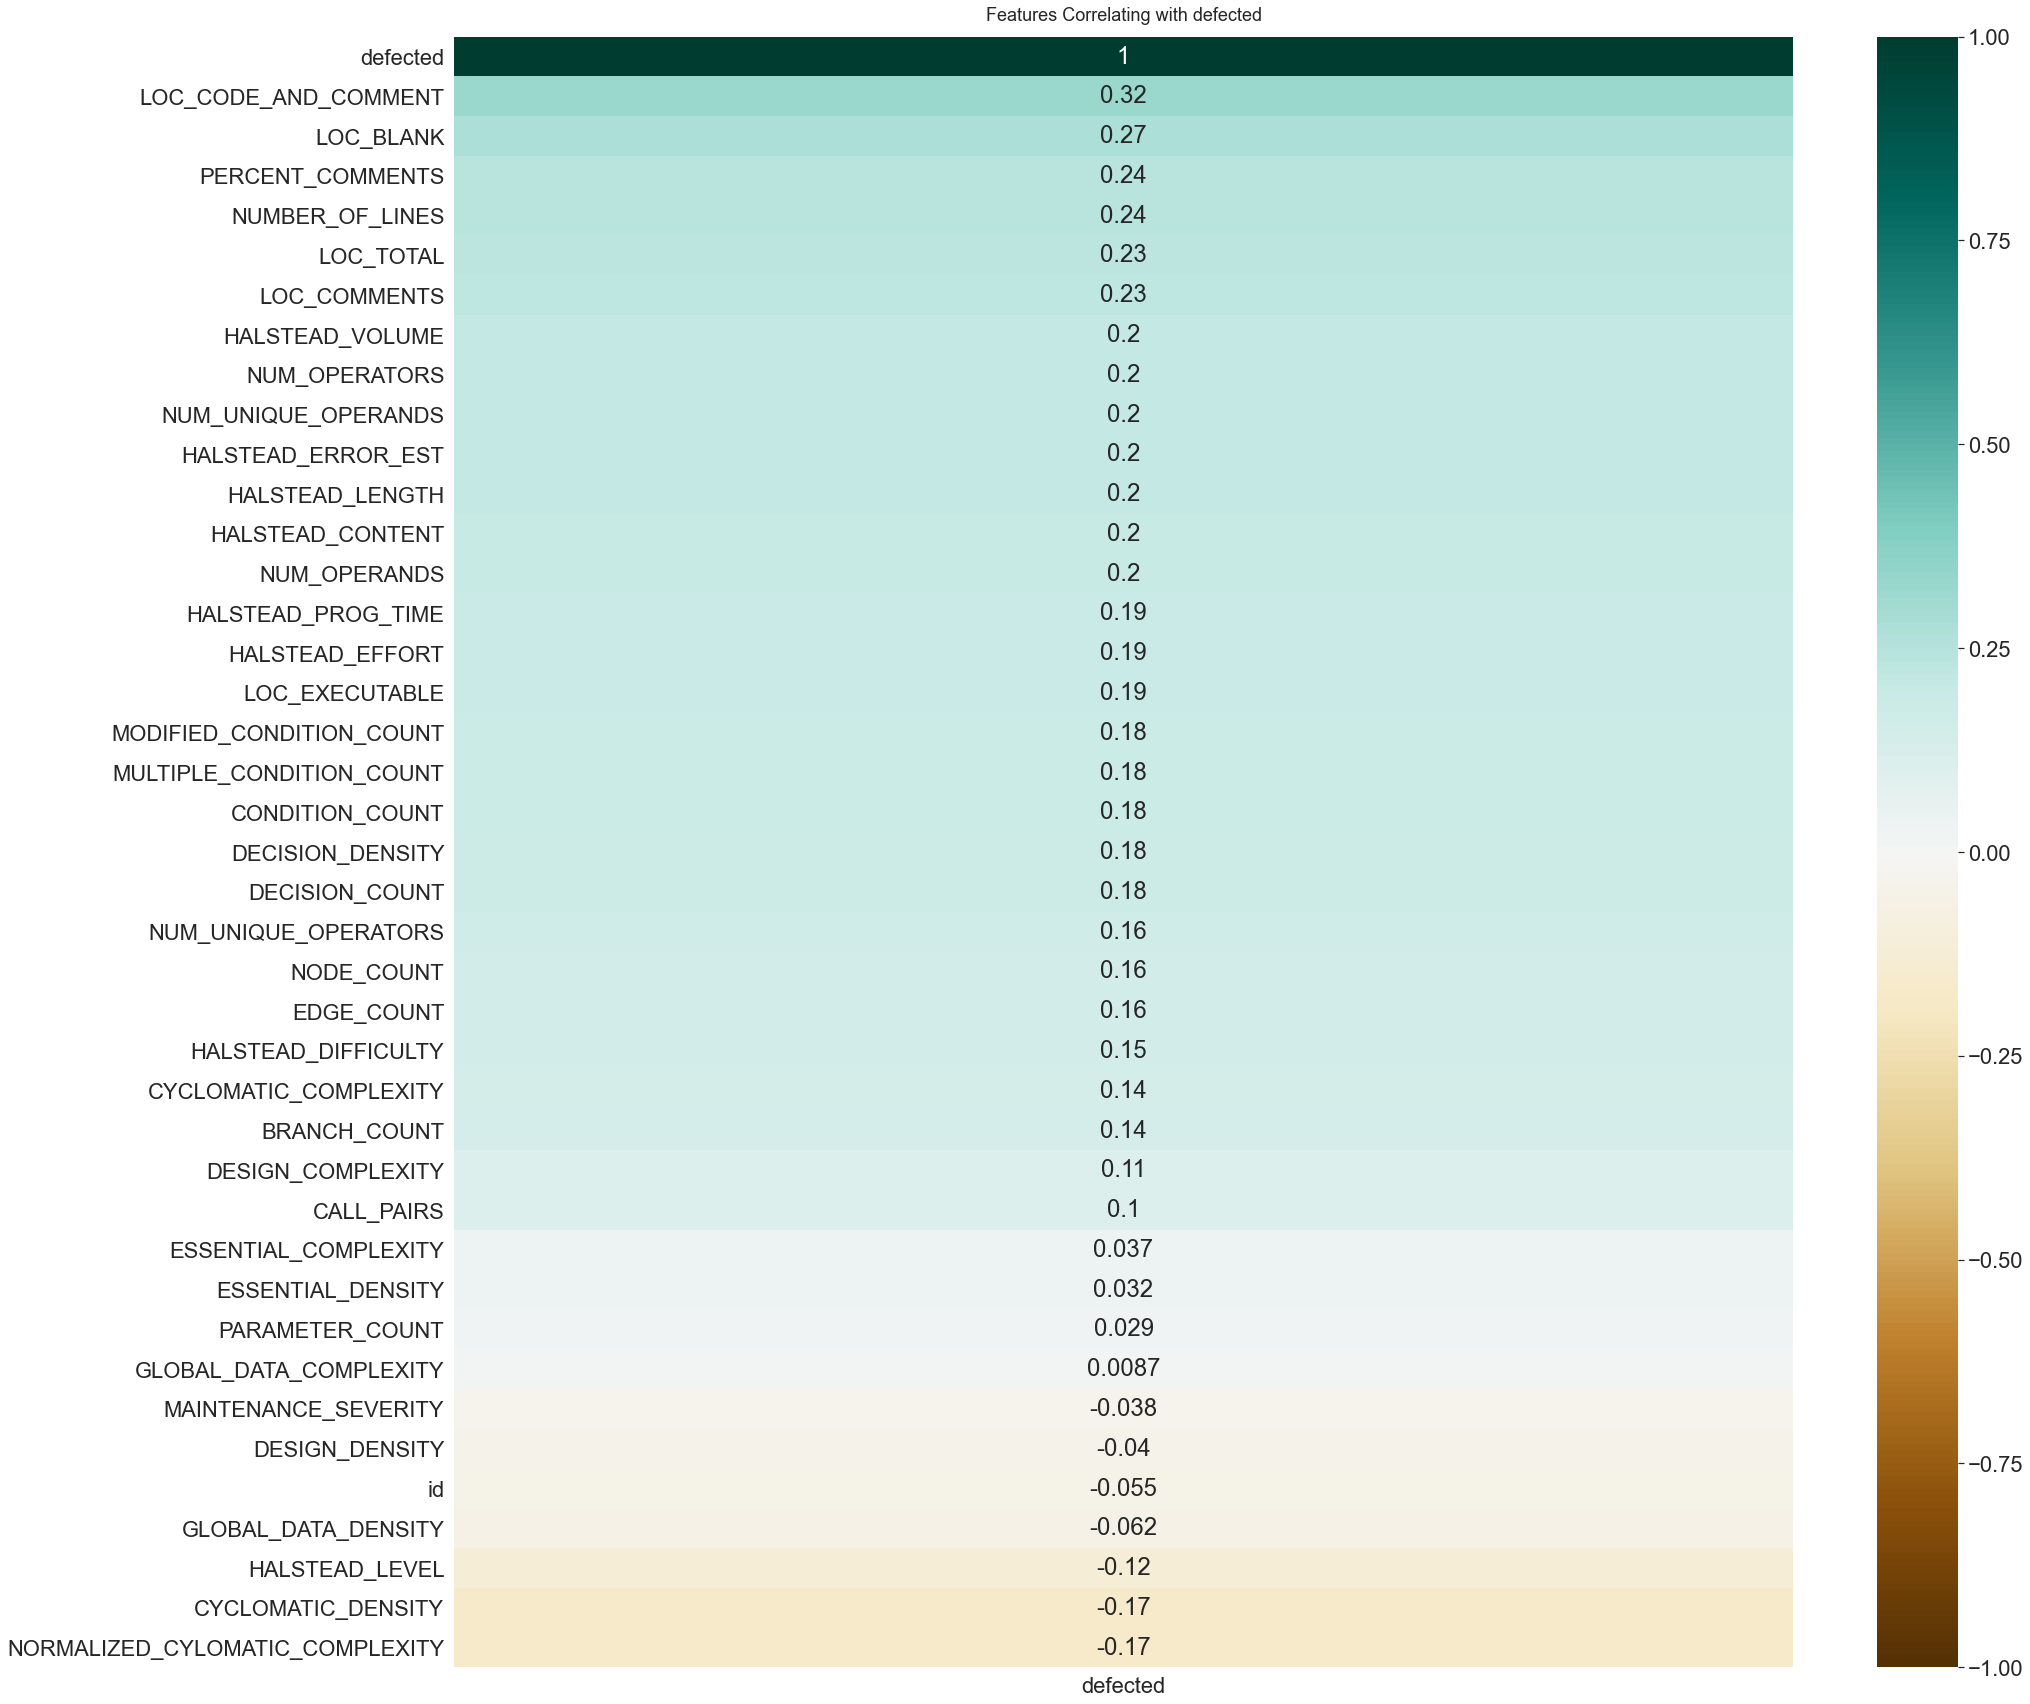

In [45]:
plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(df_f.corr(method = 'spearman')[['defected']].sort_values(by='defected', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with defected', fontdict={'fontsize':18}, pad=16);

### Inutively, the number of lines of codes and comments, along with the number of unique operands and operators and their totals, have a slightly positive linear correlation with defective rate.

In [138]:
df_f_op = df_f.drop(['id','GLOBAL_DATA_COMPLEXITY','GLOBAL_DATA_DENSITY','defected'], axis = 1)
df_f_op

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL
0,16,13,1,6,11,20,7,0.24,8,2.5,...,10,17,0.12,68,81,31,21,57,42.50,29
1,2,7,0,0,7,10,4,0.29,4,2.5,...,5,9,0.17,9,22,5,8,24,33.33,14
2,1,13,5,0,0,22,7,0.37,10,2.2,...,11,23,0.33,38,53,19,19,21,0.00,19
3,8,3,1,0,1,4,2,0.14,2,2.0,...,2,6,0.08,32,38,19,13,24,6.67,14
4,1,5,2,1,1,6,3,0.15,2,3.0,...,3,9,0.13,27,33,19,14,23,9.52,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4518,4,5,5,0,3,4,3,0.27,2,NaN,...,2,15,0.15,13,15,10,6,20,21.43,11
4519,0,1,0,0,0,0,1,1.00,0,NaN,...,0,2,0.50,0,0,0,0,2,0.00,0
4520,17,1,3,0,0,0,1,0.09,0,NaN,...,0,7,0.03,19,26,11,9,31,0.00,11
4521,0,1,2,0,0,0,1,1.00,0,NaN,...,0,4,0.50,2,4,2,3,2,0.00,0


In [147]:
target_df

,defected
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
4518,0.0
4519,0.0
4520,0.0
4521,0.0


In [46]:
columns_clean2 = ['LOC_TOTAL', 'HALSTEAD_VOLUME', 'CYCLOMATIC_COMPLEXITY', 'HALSTEAD_ERROR_EST', 'HALSTEAD_EFFORT', 
                  'HALSTEAD_PROG_TIME', 'HALSTEAD_DIFFICULTY', 'defected']

In [47]:
df_b_rd = df_f[columns_clean2].copy()

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


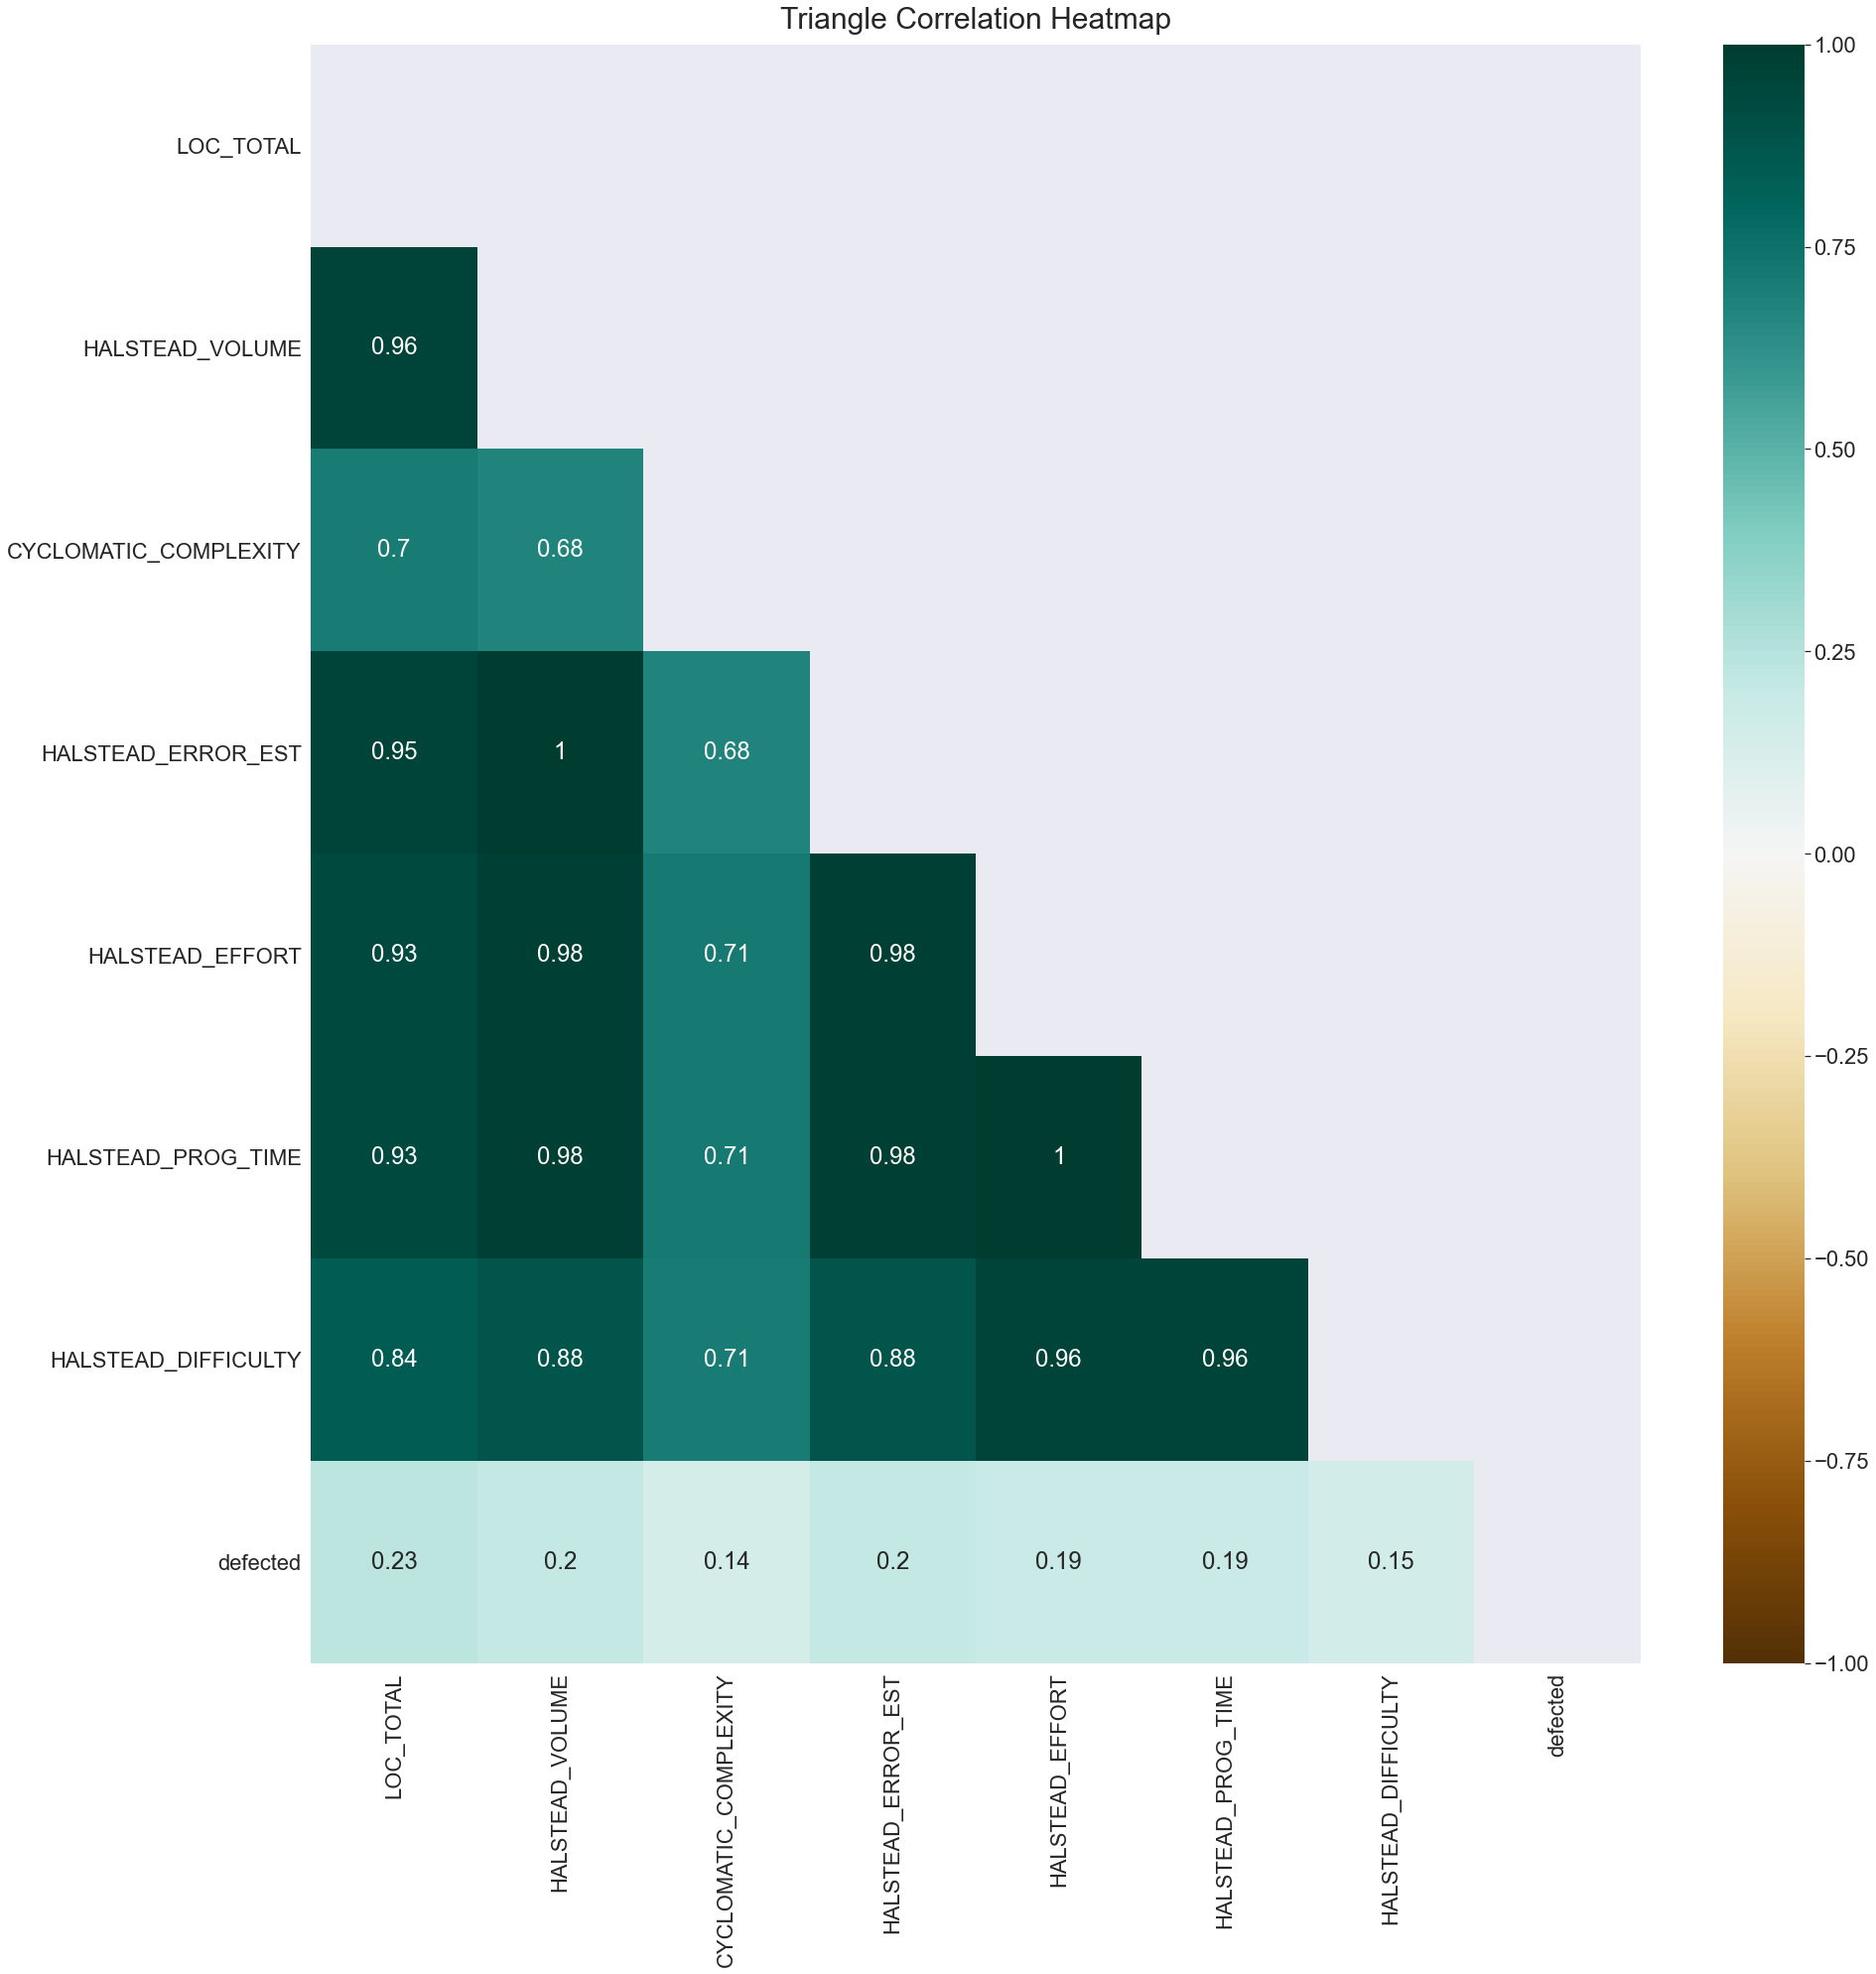

In [48]:
sns.set(font_scale=2)
np.triu(np.ones_like(df_b_rd.corr(method = 'spearman')))
plt.figure(figsize=(30, 30))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_b_rd.corr(method = 'spearman'), dtype=np.bool))
heatmap = sns.heatmap(df_b_rd.corr(method = 'spearman'), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':30}, pad=16);

There is heavey dependece between HALSTEAD values but not as much for the cyclomatic complexity, overall the values we are interested in have postive correlations. 

### Redesign recomendations implemented
if measures outside of these ranges then a redesign is suggested

In [49]:
# Calculated measures
# e = 464758.0 (b = e**(2/3)/3000)
# t = 25820 (e/18)
#464758/20

In [50]:
# Columns to Focus
# 1. Number Of Lines < 400
# 2. HALSTEAD_VOLUME(V) < 1000 & >20
# 3. CYCLOMATIC_COMPLEXITY < 15 (can be skipped)
# 4. bugs (HALSTEAD_ERROR_EST) < 2
# 5. HALSTEAD_EFFORT(e) < 464758.0 (based on b = e**(2/3)/3000)
# 6. HALSTEAD_PROG_TIME (t) < 25820 (based on t = e/18)
# 7. HALSTEAD_DIFFICULTY (d) < 23237.9 (based on e = v*d)


In [51]:
columns_clean2 = ['LOC_TOTAL', 'HALSTEAD_VOLUME', 'CYCLOMATIC_COMPLEXITY', 'HALSTEAD_ERROR_EST', 'HALSTEAD_EFFORT', 
                  'HALSTEAD_PROG_TIME', 'HALSTEAD_DIFFICULTY', 'defected']

In [52]:
df_clean2 = df_f[columns_clean2].copy()


In [53]:
clean_condition = (df_clean2['LOC_TOTAL'] < 400) & (df_clean2['HALSTEAD_VOLUME'] < 1000) & (df_clean2['HALSTEAD_VOLUME'] > 20) & (df_clean2['CYCLOMATIC_COMPLEXITY'] < 15) & (df_clean2['HALSTEAD_ERROR_EST'] < 2) & (df_clean2['HALSTEAD_EFFORT'] < 464758.0) & (df_clean2['HALSTEAD_PROG_TIME'] < 25820) & (df_clean2['HALSTEAD_DIFFICULTY'] < 23237.9)

In [54]:
df_clean2['REDESIGN_STATUS'] = pd.DataFrame(clean_condition)

In [55]:
# 0 if no changes
# 1 is Redsign needed
df_clean2['REDESIGN_STATUS'] = [0 if evaluation == True else 1 for evaluation in df_clean2['REDESIGN_STATUS']]

### Spearman correlations on final features for prediction

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


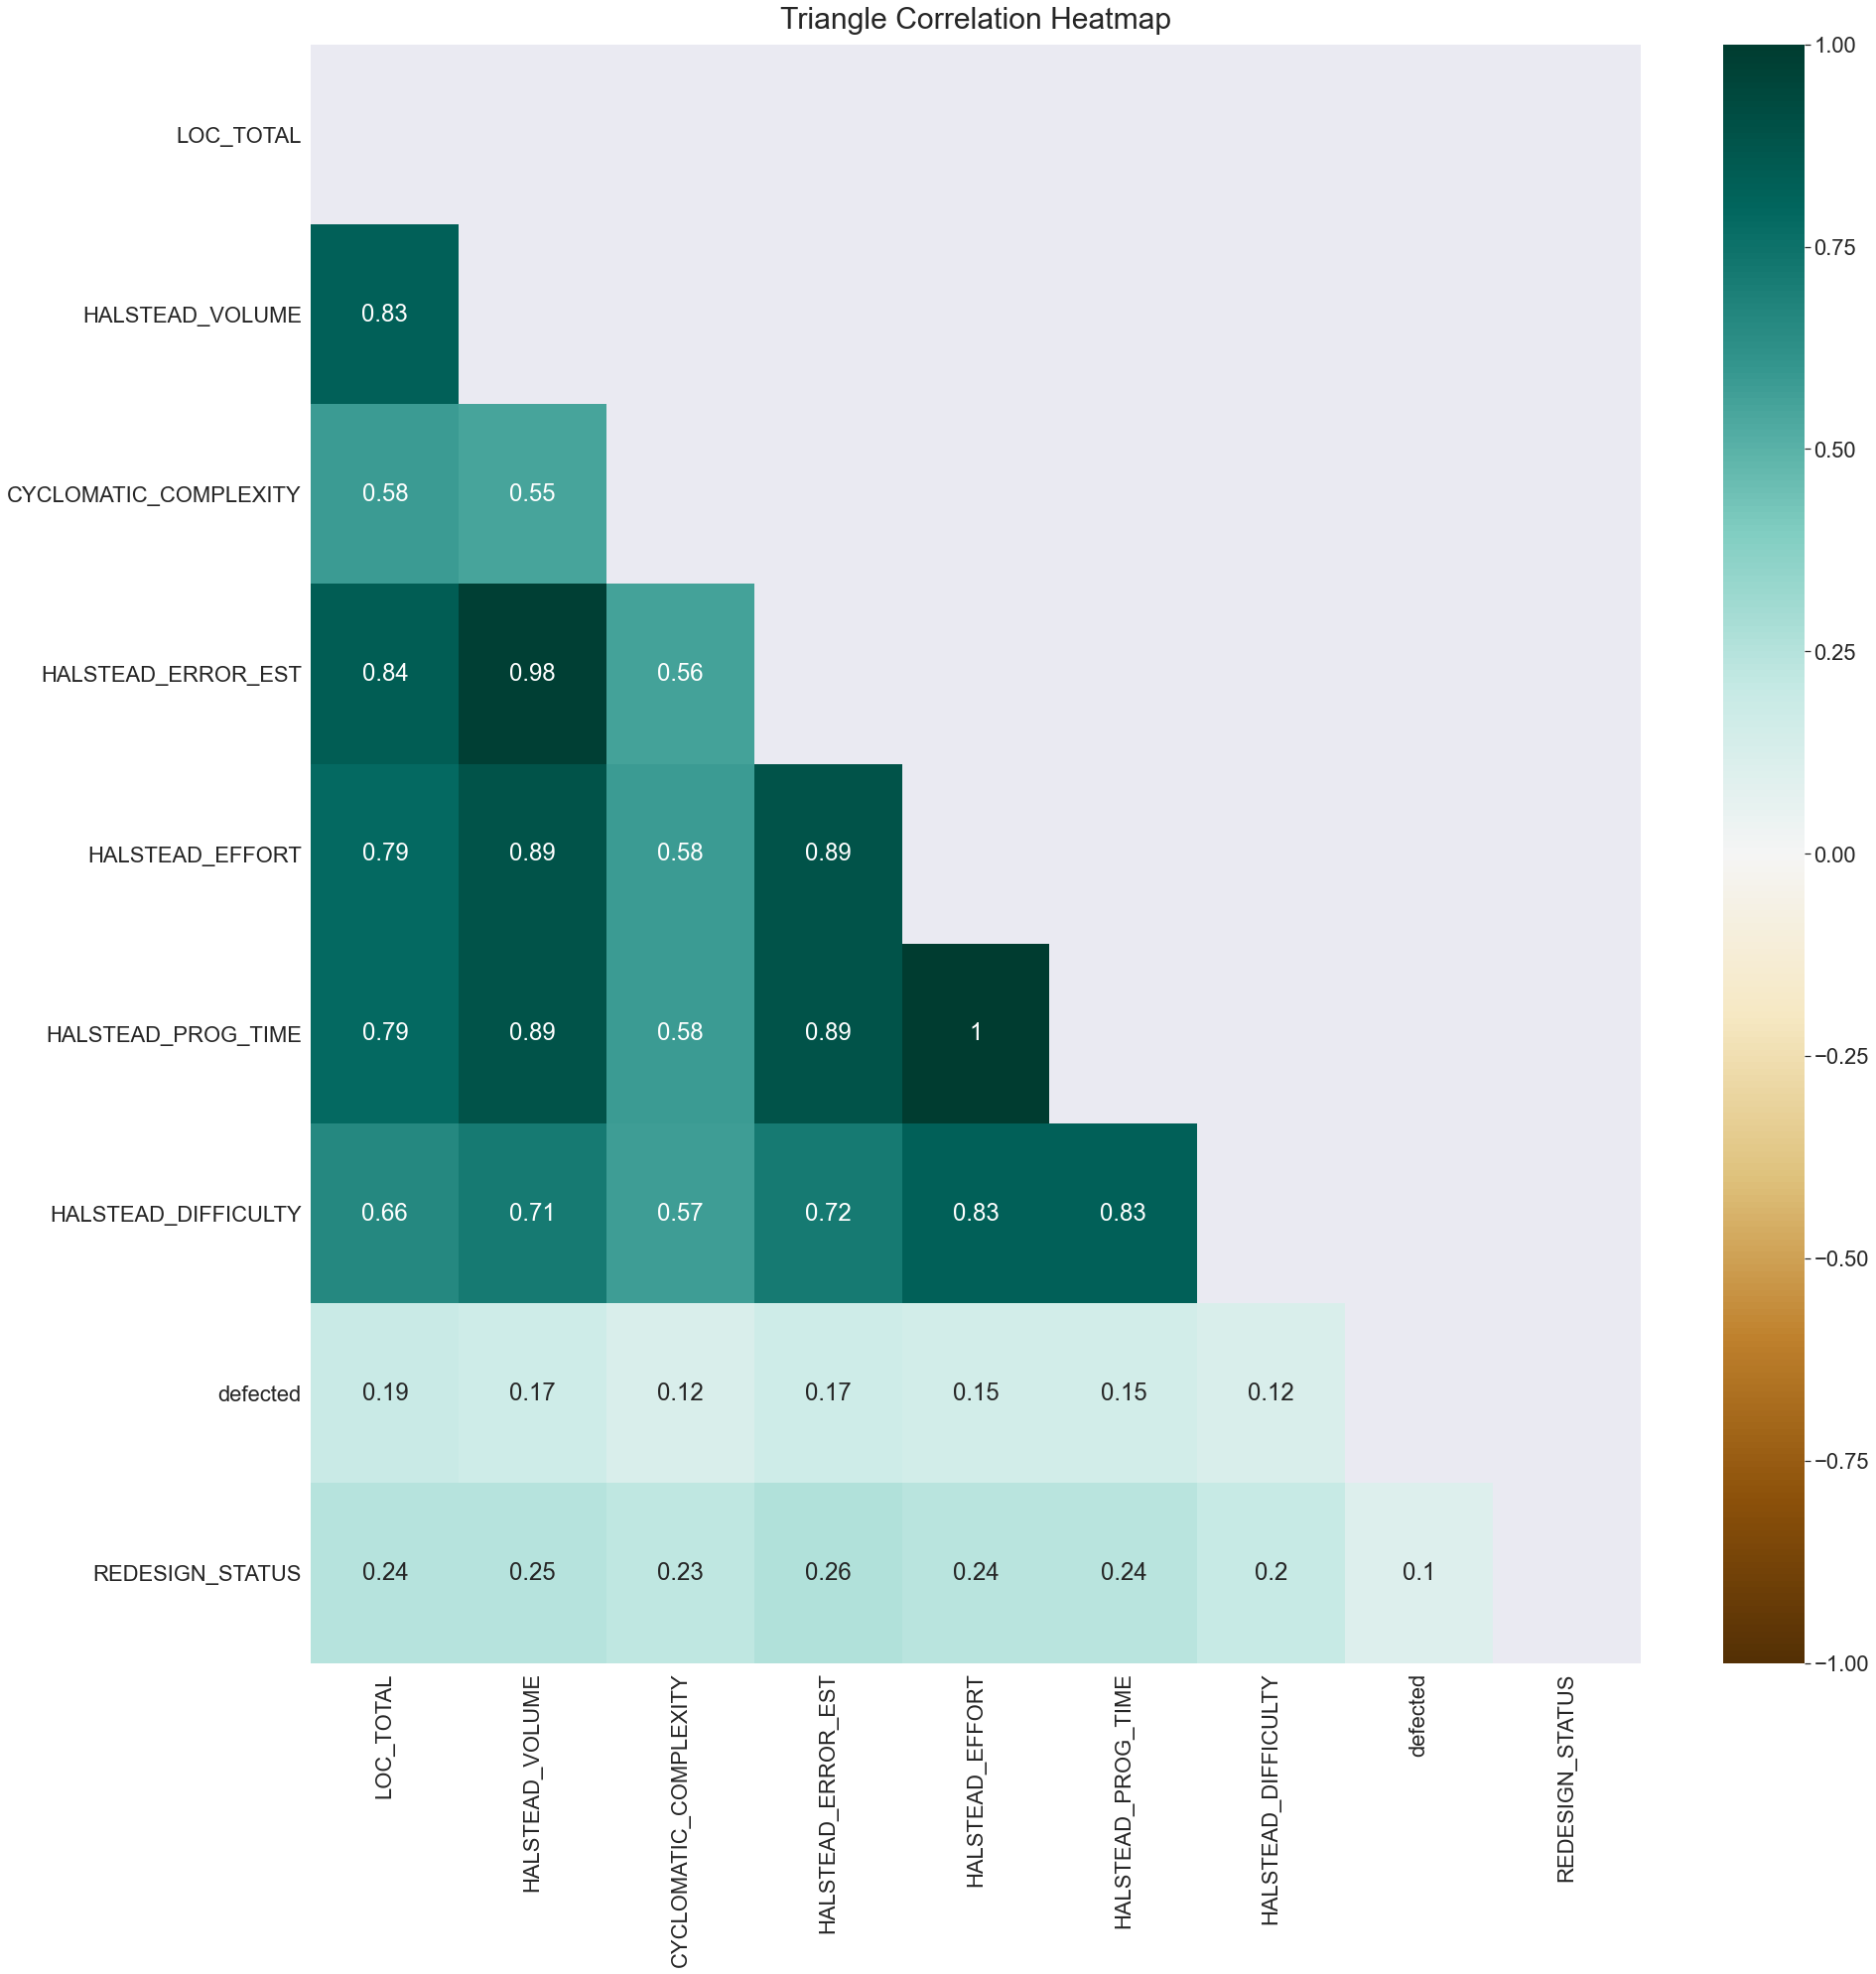

In [56]:
sns.set(font_scale=2)
np.triu(np.ones_like(df_clean2.corr(method = 'spearman')))
plt.figure(figsize=(30, 30))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_clean2.corr(method = 'kendall'), dtype=np.bool))
heatmap = sns.heatmap(df_clean2.corr(method = 'kendall'), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':30}, pad=16);

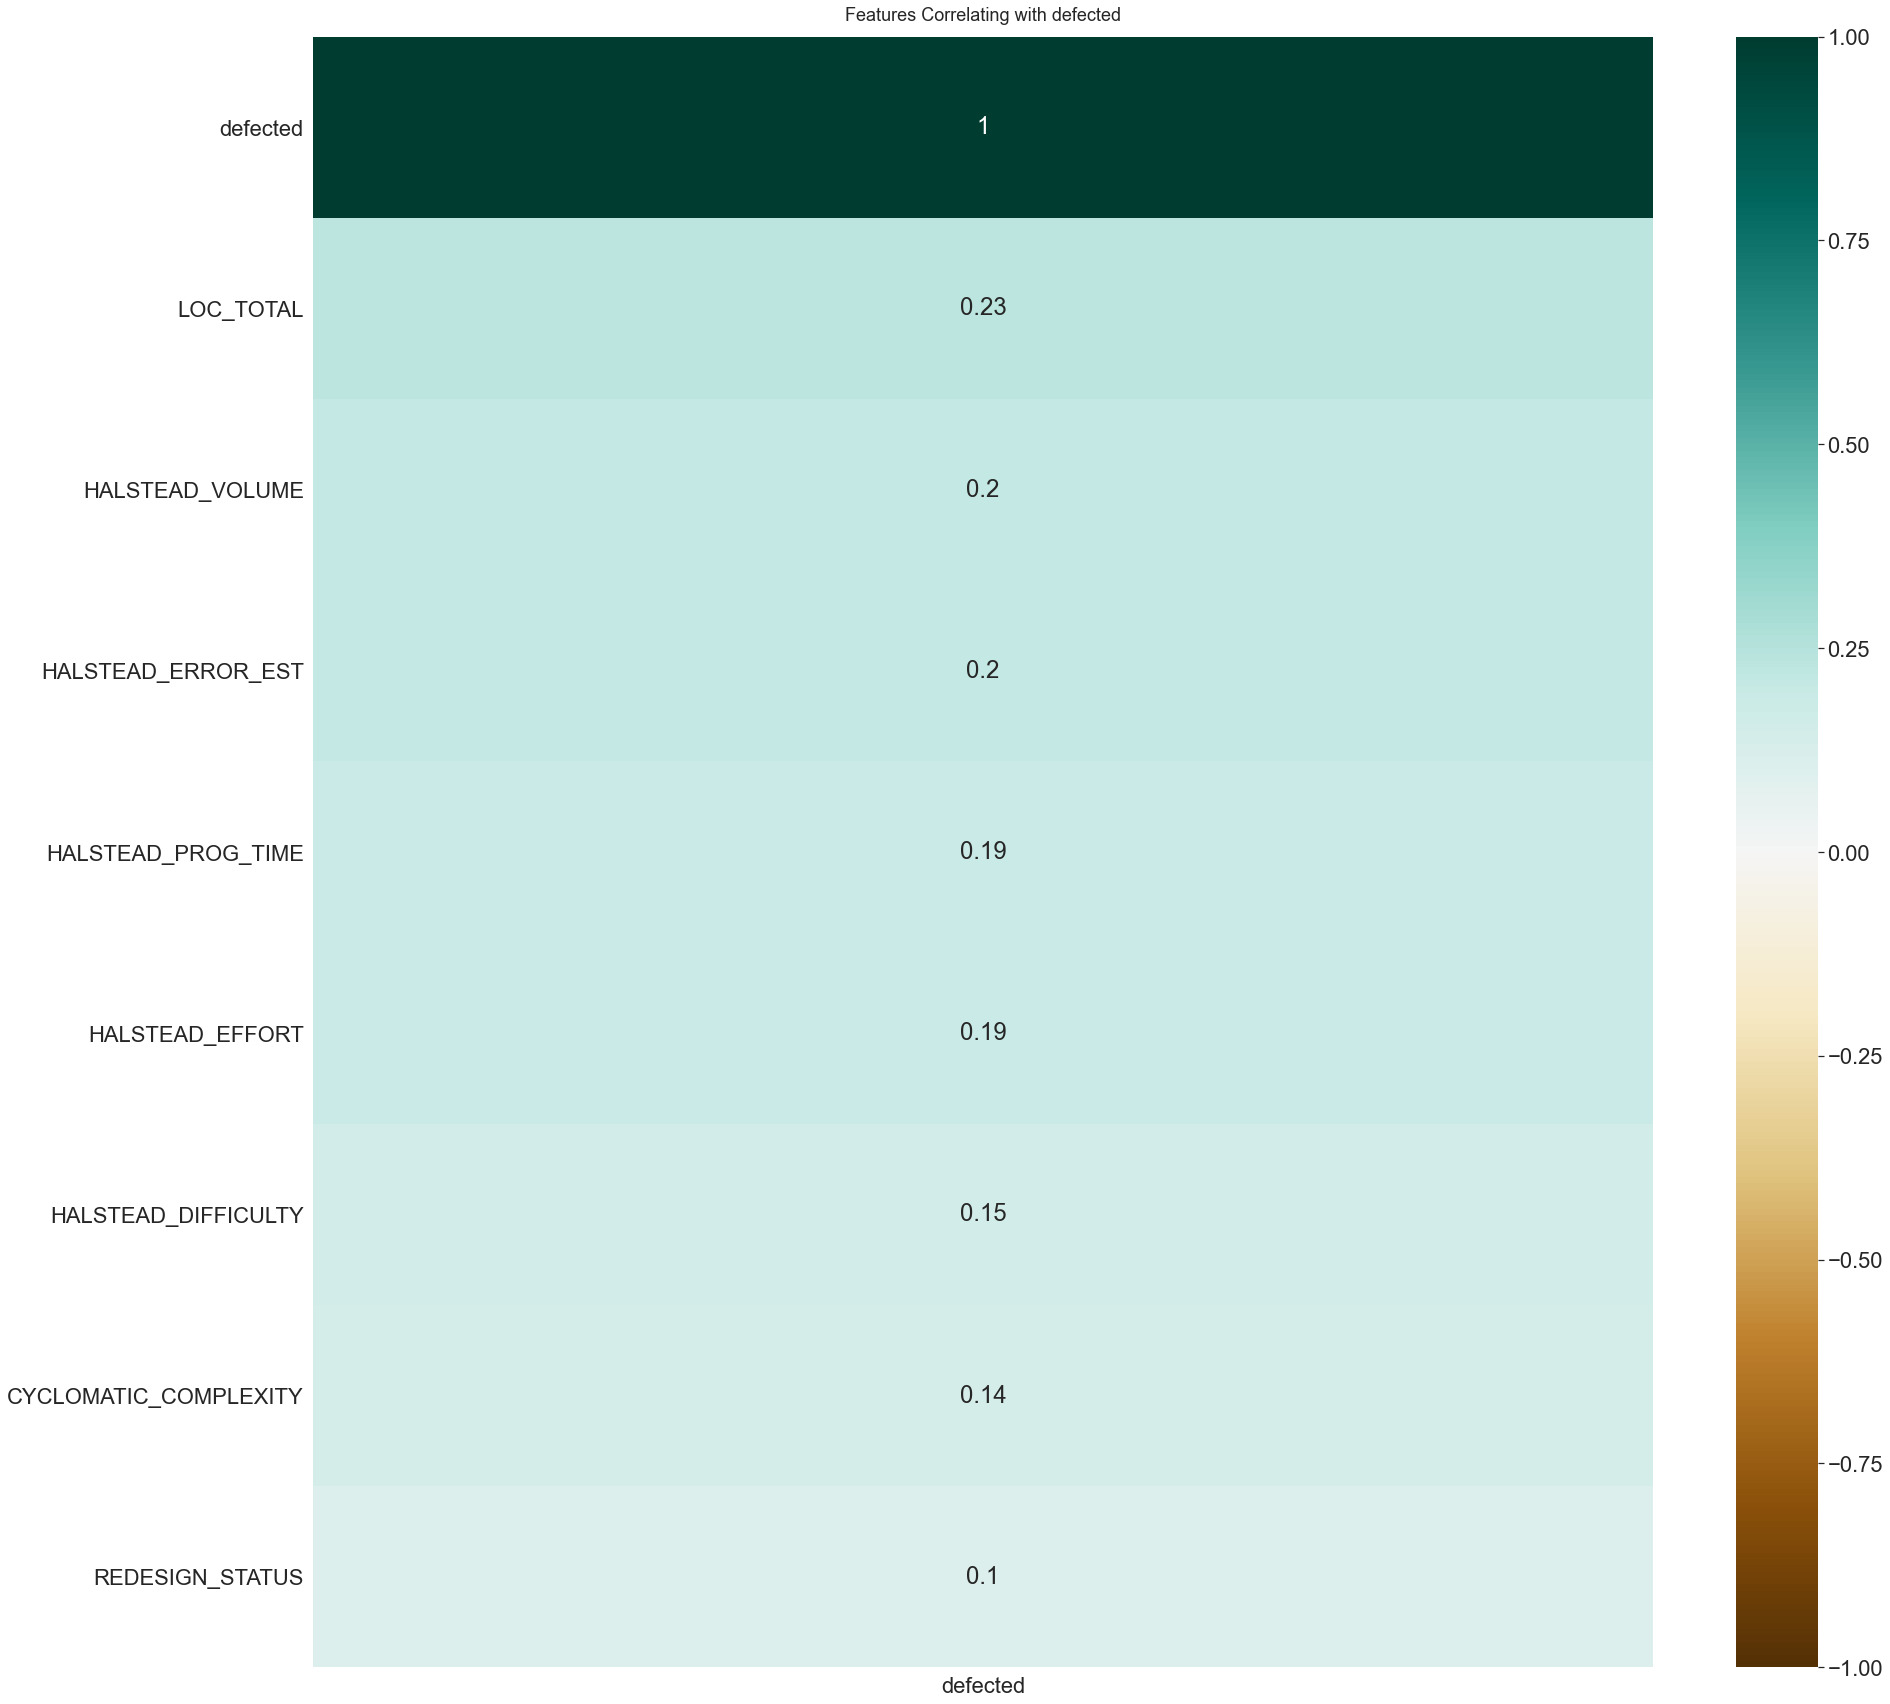

In [57]:
plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(df_clean2.corr(method = 'spearman')[['defected']].sort_values(by='defected', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with defected', fontdict={'fontsize':18}, pad=16);

We see that there is minimal correlation between redesign status and defects

### Problem with Spearmans Correlation

 Spearmans correlation, like other correlations is more preferrable when features and targets are continuous values. The defects and resign column are binary, thus using spearmans may give us inaacuracte resutls. The solution lies in using Jaacard similairty and  Point Biserial Correlation to study relationships between the features and the target.

### Jaccard similairty

In [157]:
jac_sim = 1 - pairwise_distances(df_clean2.T, metric = "hamming")
jac_sim = pd.DataFrame(jac_sim, index=df_clean2.columns, columns=df_clean2.columns)


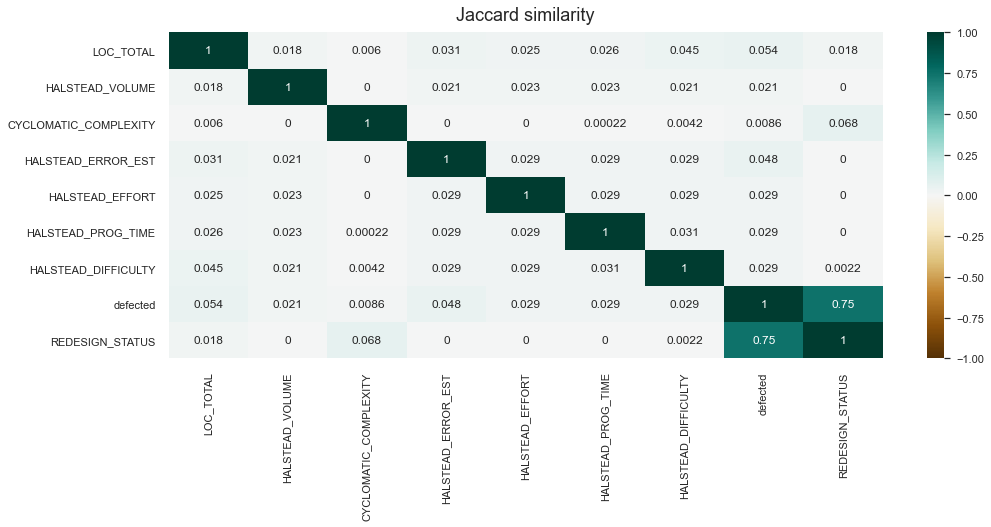

In [158]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(jac_sim, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Jaccard similarity', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

We see a 75% similarity between redesign and defected which is relatively high and corresponds to the 75% match of the redesign and defected. 

### Point Biserial Correlation

[0.14897790136875214, 0.07899145350856838, 0.04791649339523184, 0.07876185168511389, 0.0032679802675460025, 0.0032679781176094577, 0.05935342291483218, 0.9999999999999905, 0.10296813164041384]


Text(0.5, 1.0, 'PBC of different features to defects')

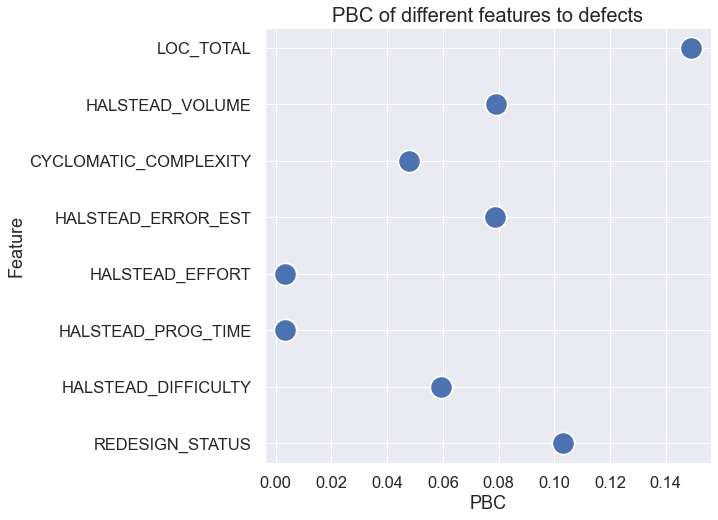

In [156]:
corr_list = []
y = df_clean2['defected'].astype(float)


for column in df_clean2:
    x=df_clean2[column]
    corr = stats.pointbiserialr(list(x), list(y))
    corr_list.append(corr[0])
print(corr_list)
pbc_dict = {'Feature': ['LOC_TOTAL', 'HALSTEAD_VOLUME', 'CYCLOMATIC_COMPLEXITY',
       'HALSTEAD_ERROR_EST', 'HALSTEAD_EFFORT', 'HALSTEAD_PROG_TIME',
       'HALSTEAD_DIFFICULTY', 'defected', 'REDESIGN_STATUS'], 'PBC': corr_list}

df_pbc = pd.DataFrame(pbc_dict)


df_pbc = df_pbc.drop([7])

sns.set(font_scale=1.5)
sns.scatterplot(data=df_pbc , x = 'PBC', y="Feature", cmap='BrBG', s = 500)
sns.set(rc={'figure.figsize':(12,12)})
fontsize = 15
plt.title('PBC of different features to defects',fontsize=20)





PBC indicates that LOC_TOTAL has the highest correlation out of all the value. These correlation coefficient are all positive, this indicates that when defected takes on the value “1” that the lines of code tends to take on higher values compared to when the defected takes on the value “0.” This is another confirmation that more lines of code correlates to higher defects. Redesign here should be disregarded as itself is a binary data type, and this test is only for binary vs. continuous. 

<BarContainer object of 2 artists>

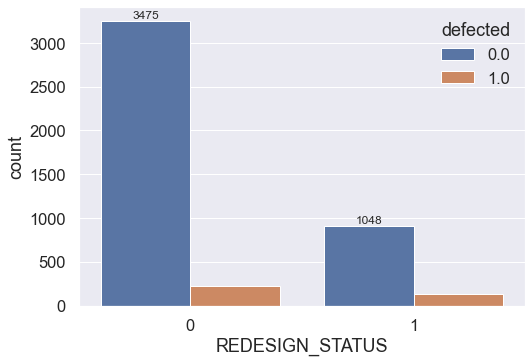

In [155]:
sns.set(font_scale=1.5)
x = sns.countplot(data=df_clean2, x='REDESIGN_STATUS', hue='defected')
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(8,8)})
abs_values = df_clean2['REDESIGN_STATUS'].value_counts(ascending=False).values
abs_values
x.bar_label(container=x.containers[0], labels=abs_values)
x.containers[0]


In [69]:
df_clean2['defected'].value_counts()

0.0    4165
1.0     358
Name: defected, dtype: int64

In [70]:
df_clean2['REDESIGN_STATUS'].value_counts()

0    3475
1    1048
Name: REDESIGN_STATUS, dtype: int64

Our Reccomended metrics flag about many times more programs than actual defects

# Redesign does suggest redesigning programs that are not defective, there are about 3 many times more redesigns recommendations than actual defects

In [71]:
b = np.where(df_clean2['defected'] == df_clean2['REDESIGN_STATUS'])
df_clean3 = df_clean2[df_clean2['defected'] == df_clean2['REDESIGN_STATUS']]
df_clean3

,LOC_TOTAL,HALSTEAD_VOLUME,CYCLOMATIC_COMPLEXITY,HALSTEAD_ERROR_EST,HALSTEAD_EFFORT,HALSTEAD_PROG_TIME,HALSTEAD_DIFFICULTY,defected,REDESIGN_STATUS
0,29,849.37,7,0.28,19562.81,1086.82,23.03,0.0,0
2,19,477.56,7,0.16,9073.67,504.09,19.00,0.0,0
3,14,350.00,2,0.12,3831.58,212.87,10.95,0.0,0
4,20,302.66,3,0.10,3010.71,167.26,9.95,0.0,0
5,29,908.66,6,0.30,19213.78,1067.43,21.15,0.0,0
...,...,...,...,...,...,...,...,...,...
4516,7,148.46,1,0.05,2041.35,113.41,13.75,0.0,0
4517,81,1375.96,1,0.46,61064.32,3392.46,44.38,1.0,1
4518,11,112.00,3,0.04,436.80,24.27,3.90,0.0,0
4520,11,194.49,1,0.06,1511.69,83.98,7.77,0.0,0


# Redesign suggestions correctly match defects about 75% of the time

In [72]:
b = np.where(df_clean2['defected'] == df_clean2['REDESIGN_STATUS'])
df_clean3 = df_clean2[df_clean2['defected'] == df_clean2['REDESIGN_STATUS']]
df_clean3

,LOC_TOTAL,HALSTEAD_VOLUME,CYCLOMATIC_COMPLEXITY,HALSTEAD_ERROR_EST,HALSTEAD_EFFORT,HALSTEAD_PROG_TIME,HALSTEAD_DIFFICULTY,defected,REDESIGN_STATUS
0,29,849.37,7,0.28,19562.81,1086.82,23.03,0.0,0
2,19,477.56,7,0.16,9073.67,504.09,19.00,0.0,0
3,14,350.00,2,0.12,3831.58,212.87,10.95,0.0,0
4,20,302.66,3,0.10,3010.71,167.26,9.95,0.0,0
5,29,908.66,6,0.30,19213.78,1067.43,21.15,0.0,0
...,...,...,...,...,...,...,...,...,...
4516,7,148.46,1,0.05,2041.35,113.41,13.75,0.0,0
4517,81,1375.96,1,0.46,61064.32,3392.46,44.38,1.0,1
4518,11,112.00,3,0.04,436.80,24.27,3.90,0.0,0
4520,11,194.49,1,0.06,1511.69,83.98,7.77,0.0,0


75 percent of the time the redesign matches the defect, this also is a similar number to our jaccard similarity

In [73]:
match = len(df_clean3.index)
total = len(df_clean2.index)


ratio = match/total
# about 75 percent of the time the redesign matches the defect
ratio



0.7492814503648021

## Outliers and feature relations

### Z-score outliers

In [74]:
#df_clean2 = df_clean2(['defected','REDESIGN_STATUS'], axis = 1)

In [75]:
z_scores = stats.zscore(df_clean2)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_clean2_z = df_clean2[filtered_entries]

In [76]:
#sns.pairplot(df_clean2_z)

In [77]:
df_clean2_z['defected'].value_counts()


0.0    4054
Name: defected, dtype: int64

In [78]:
df_clean2_z['REDESIGN_STATUS'].value_counts()

0    3252
1     802
Name: REDESIGN_STATUS, dtype: int64

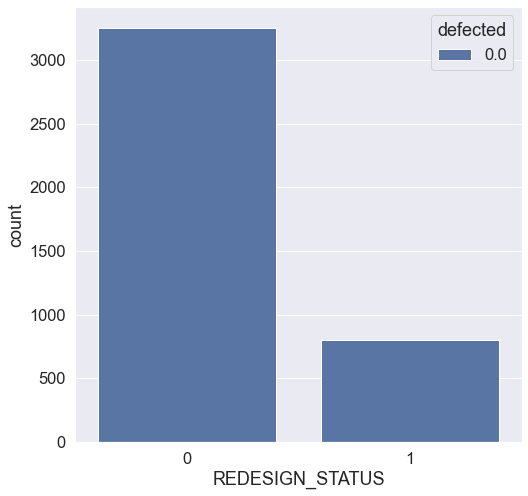

In [79]:
sns.set(font_scale=1.5)
x = sns.countplot(data=df_clean2_z, x='REDESIGN_STATUS', hue='defected')
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(8,8)})

After z-scores have been applied we see a linear relationship between all the features except Cyclomatic complexity 

Z-scores are not preferrred for features that are not normally distributed which some of our features are so we disregard it.

### IQR outliers

In [80]:
Q1 = df_clean2.quantile(0.25)
Q3 = df_clean2.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

LOC_TOTAL                   20.000
HALSTEAD_VOLUME            546.170
CYCLOMATIC_COMPLEXITY        5.000
HALSTEAD_ERROR_EST           0.190
HALSTEAD_EFFORT          11815.445
HALSTEAD_PROG_TIME         656.415
HALSTEAD_DIFFICULTY         14.695
defected                     0.000
REDESIGN_STATUS              0.000
dtype: float64


In [81]:
df_clean2_iqr = df_clean2[~((df_clean2< (Q1 - 1.5 * IQR)) |(df_clean2> (Q3 + 1.5 * IQR))).any(axis=1)]

In [82]:
#sns.pairplot(df_clean2_iqr)

In [83]:
df_clean2_iqr['defected'].value_counts()

0.0    3200
Name: defected, dtype: int64

In [84]:
df_clean2_iqr['REDESIGN_STATUS'].value_counts()

0    3200
Name: REDESIGN_STATUS, dtype: int64

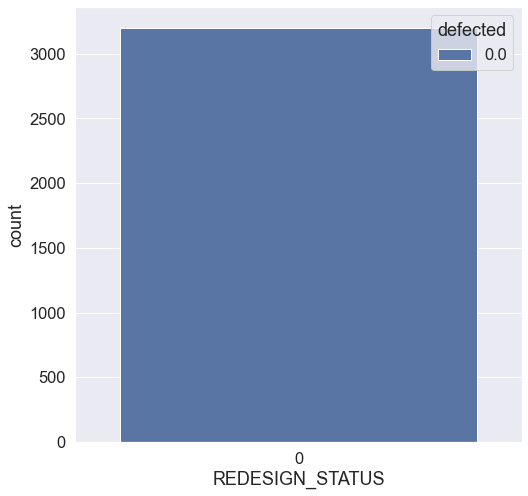

In [85]:
sns.set(font_scale=1.5)
x = sns.countplot(data=df_clean2_iqr, x='REDESIGN_STATUS', hue='defected')
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(8,8)})

We drop the values of the data outside of the range of the IQR plot,  ranges are determined by the equation Q1-1.5*IQR for the low end outliers and Q3 + 1.5 * IQR for the high end.

IQR removes 854 more programs than Z-score outliers removal, removing all the values that were flagged as defective or redesign needed. We see greater linearity between most features and less of a relation between cyclomatic complexity and the other features. 


# Software prediction classifier

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting, like decision trees they can be done on multiple data types without need for feature normalization. Decision trees by themselves tend to overfit, thus a random forest is used.

### preparing features(predictors) and targets

In [86]:
target_df = df_clean2['defected']
target_df = pd.DataFrame(target_df)
target_df.value_counts()

defected
0.0         4165
1.0          358
dtype: int64

In [162]:
predictors_df = df_clean2.drop(labels = ['defected','REDESIGN_STATUS'], axis = 1)
predictors_df

,LOC_TOTAL,HALSTEAD_VOLUME,CYCLOMATIC_COMPLEXITY,HALSTEAD_ERROR_EST,HALSTEAD_EFFORT,HALSTEAD_PROG_TIME,HALSTEAD_DIFFICULTY
0,29,849.37,7,0.28,19562.81,1086.82,23.03
1,14,114.71,4,0.04,825.94,45.89,7.20
2,19,477.56,7,0.16,9073.67,504.09,19.00
3,14,350.00,2,0.12,3831.58,212.87,10.95
4,20,302.66,3,0.10,3010.71,167.26,9.95
...,...,...,...,...,...,...,...
4518,11,112.00,3,0.04,436.80,24.27,3.90
4519,0,0.00,1,0.00,0.00,0.00,0.00
4520,11,194.49,1,0.06,1511.69,83.98,7.77
4521,0,13.93,1,0.00,20.90,1.16,1.50


### Random search optimized Randomforrestclassifier using SMOTE for balancing the defects and non-defect totals

To solve the balancing issue we use SMOTE
Synthetic Minority Oversampling Technique, or SMOTE
“SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.”



In [193]:


model = RandomForestClassifier(criterion = 'entropy',max_features = 'sqrt',bootstrap = True, max_depth = 110,min_samples_leaf = 1, min_samples_split = 2, n_estimators = 1400, oob_score = True)


X_train, X_test, y_train, y_test = train_test_split(predictors_df, target_df, test_size = 0.3, random_state = 42, shuffle=True, stratify = target_df)
sm = SMOTE(random_state = 42, k_neighbors = 10)
X_res, y_res = sm.fit_resample(X_train, y_train)
y_res = pd.DataFrame(y_res)
model.fit(X_res, y_res)
#sm#tom = SMOTETomek(random_state=139)

#X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)
#model.fit(X_train_smtom, y_train_smtom)
#smenn = SMOTEENN()
#X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)
#model.fit(X_train_smenn, y_train_smenn)
#
#ada = ADASYN(random_state=130)
#X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
#model.fit(X_train_ada, y_train_ada)
#model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#Accuracy score
from sklearn.metrics import accuracy_score
print("ACC: ",accuracy_score(y_pred,y_test))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93      1250
         1.0       0.29      0.48      0.36       107

    accuracy                           0.87      1357
   macro avg       0.62      0.69      0.64      1357
weighted avg       0.90      0.87      0.88      1357

[[1125  125]
 [  56   51]]
ACC:  0.866617538688283


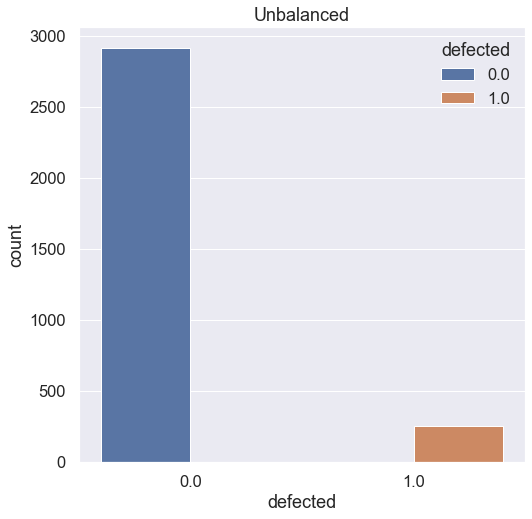

In [179]:
sns.set(font_scale=1.5)
x = sns.countplot(data=y_train, x='defected', hue='defected').set(title='Unbalanced')
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(8,8)})

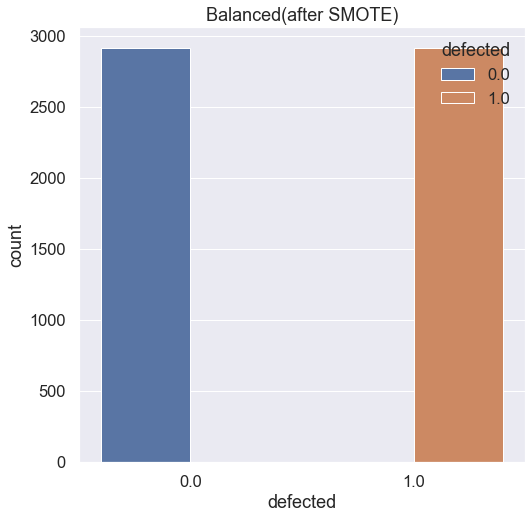

In [180]:
sns.set(font_scale=1.5)
x = sns.countplot(data=y_res, x='defected', hue='defected').set(title='Balanced(after SMOTE)')
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(8,8)})

In [177]:
rf = RandomForestRegressor(n_estimators=100)



# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

search = RandomizedSearchCV(rf,
                           random_grid,
                           scoring = 'roc_auc',
                           cv = 5,
                           n_iter = 60,
                           random_state = 10,
                           n_jobs = 4,
                           refit = True)
search.fit(X_train, y_train)

search.best_params_





A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [181]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

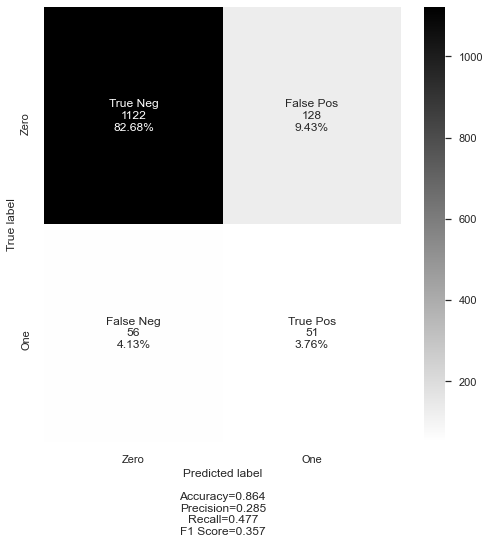

In [182]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [183]:
pred_prob = model.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

0.7604710280373831


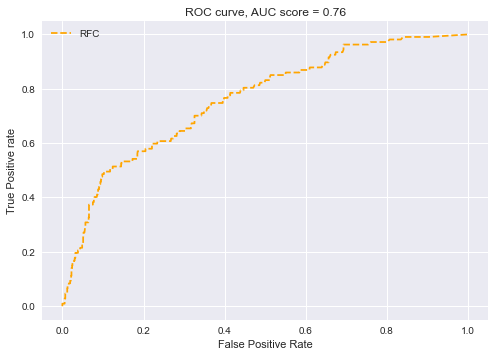

In [184]:
#from sklearn.metrics import roc_curve
# roc curve for models
#fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

from sklearn.metrics import roc_auc_score
# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob[:,1])

print(auc_score1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='RFC')


# title
plt.title('ROC curve, AUC score = 0.76' )
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### The auc values between 0.7 and 0.8 are generally acceptable prediction systems

# Feature importance

## Shap

SHAP calculates the impact of every feature to the target variable (called shap value) using combinatorial calculus and retraining the model over all the combination of features that contains the one we are considering. The average absolute value of the impact of a feature against a target variable can be used as a measure of its importance. 


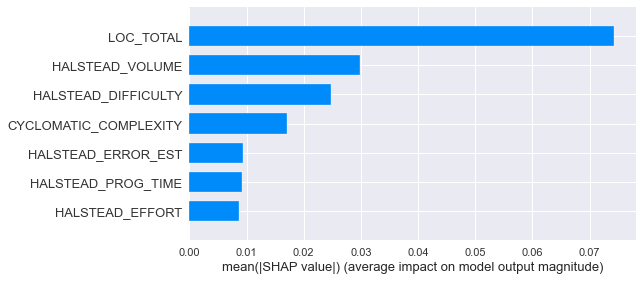

In [64]:

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

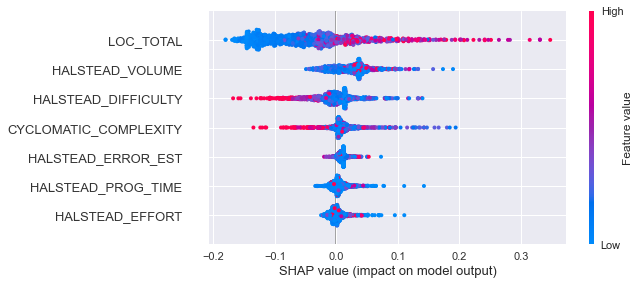

In [65]:
shap.summary_plot(shap_values, X_test)

Each point of every row is a record of the test dataset. The features are sorted from the most important one to the less important. High values have more impact on the model. Negative values indicate a negative correlation with defects, and positive values indicate a positive one.

Note we must remember this is not a causation we see, it is just want features are more important
to make the model predict correctly.

## Lime

LIME provides local model interpretability. LIME modifies a single data sample by tweaking the feature values and observes the resulting impact on the output. Often, this is also related to what humans are interested in when observing the output of a model. 

In [81]:
predict_fn_rf = lambda x: model.predict_proba(x).astype(float)
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train.columns,class_names=['no defect','defect'],kernel_width=5)

In [87]:
X_test.loc[[10]]

,LOC_TOTAL,HALSTEAD_VOLUME,CYCLOMATIC_COMPLEXITY,HALSTEAD_ERROR_EST,HALSTEAD_EFFORT,HALSTEAD_PROG_TIME,HALSTEAD_DIFFICULTY
10,7,108.42,3,0.04,851.86,47.33,7.86


In [89]:
y_test.loc[[10]]

,defected
10,0.0


In [90]:
choosen_instance = X_test.loc[[10]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=7)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [144]:
from optimalflow.autoFS import dynaFS_clf

In [152]:
# Set input_form_file = False, when label values are array. Select 'True' from Pandas dataframe.

reg_fs_demo = dynaFS_clf( fs_num = 5,random_state = 13,cv = 10,input_from_file = True)

# You can find details of each selector's choice in autoFS_logxxxxx.log file in the ./test folder

reg_fs_demo.fit(predictors_df,target_df)

Now in Progress - Feature Selection Iteration: [####################] 100.0%
The optimalflow autoFS identify the top 5 important features for classification are: ['LOC_TOTAL', 'HALSTEAD_VOLUME', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_PROG_TIME'].


(5,
 ['LOC_TOTAL',
  'HALSTEAD_VOLUME',
  'HALSTEAD_DIFFICULTY',
  'HALSTEAD_EFFORT',
  'HALSTEAD_PROG_TIME'])